In [1]:
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np

In [157]:
def run_model(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None, n_minibatch=1):
    """
    Creates and runs a FTA model with the given parameters and ticks. 
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
        seed_bmi: Seed to set the agent BMIs
        seed_graph: Seed to set the graph connections
        n_minibatch: Number of mini-batches to run. n_minibatch=n is the original ABM, n=1 is a snapshot update
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)
    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjecency matrix for the agents
    # Note: For large N (i.e., mean_degree/N < 0.01), sparse arrays are more effecient
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    # Array of agent indices to activate 
    indices = np.arange(n)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Suffle the activation indicies
        random.shuffle(indices)

        for batch in np.split(indices, n_minibatch):
            # Mini-batch adjecency matrix
            A_mini = A[batch]
            # Compute the mean BMI of each agents neighbors
            b_mean = (A_mini @ b) / np.sum(A_mini, axis=1)
            # The difference between each agents BMI and its neighbors BMIs
            delta = b_mean - b[batch]
            
            # Update the agents BMI according to the following rules
            #    (1) If the magintue of delta is less than the radius, don't 
            #        update the BMI (i.e., b += 0).
            #    (2) Otherwise move the agents BMI towards the mean BMI by a step
            #        size of 0.1 or delta, whichever is smaller (i.e., b += sign(delta) * min(delta, 0.1))
            b[batch] += np.where(abs(delta) < radius, 0, np.sign(delta)*np.minimum(abs(delta), 0.1))
    
    return mean_bmi

## Seeding Tests

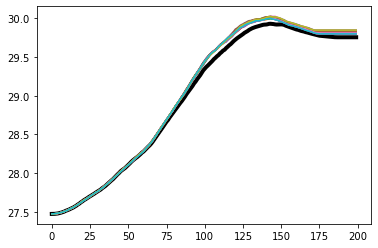

In [166]:
plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed), color="black", lw=4)

for i in range(20):
    plt.plot(run_model_stocastic(ticks=200, seed_bmi=seed, seed_graph=seed))

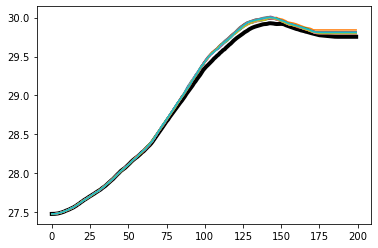

In [167]:
plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed), color="black", lw=4)

for i in range(20):
    plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed, n_minibatch=10))

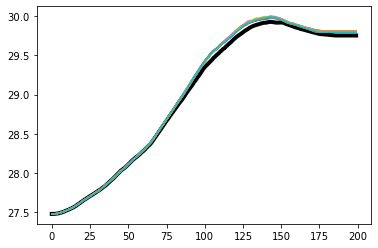

In [168]:
plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed), color="black", lw=4)

for i in range(20):
    plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed, n_minibatch=5))

## These are two faster versions of the above model with `n_minibatch` set to `1` and `n`

In [89]:
def run_model_gd(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None):
    """
    Creates and runs a FTA model with the given parameters and ticks. NOTE: The update rule
        for the model is a snapshot update, all agents change their BMIs at the same time.
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)
    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjecency matrix for the agents
    # Note: For large N (i.e., mean_degree/N < 0.01), sparse arrays are more effecient
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Compute the mean BMI of each agents neighbors
        b_mean = (A @ b) / np.sum(A, axis=0)
        # The difference between each agents BMI and its neighbors BMIs
        delta = b_mean - b
        # Update the agents BMI according to the following rules
        #    (1) If the magintue of delta is less than the radius, don't 
        #        update the BMI (i.e., b += 0).
        #    (2) Otherwise move the agents BMI towards the mean BMI by a step
        #        size of 0.1 or delta, whichever is smaller (i.e., b += sign(delta) * min(delta, 0.1))
        b += np.where(abs(delta) < radius, 0, np.sign(delta)*np.minimum(abs(delta), 0.1))
        
    return mean_bmi

In [141]:
def run_model_stocastic(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None):
    """
    Creates and runs a FTA model with the given parameters and ticks. NOTE: The update rule
        for the model is a stocastic (i.e., batch size = 1). This is equivelent to the original
        model.
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)

    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjecency matrix for the agents
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    # Array of agent indices to activate 
    indices = np.arange(n)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Suffle the agent activation indices, this RNG is NOT seeded
        random.shuffle(indices)
        
        for j in indices:
            # Compute the mean BMI of each agents neighbors
            b_mean = (A[:, j] @ b) / np.sum(A[:,j])
            # The difference between each agents BMI and its neighbors BMIs
            delta = b_mean - b[j]
            # Update the agents BMI according to the following rules
            #    (1) If the magintue of delta is less than the radius, don't 
            #        update the BMI (i.e., b += 0).
            #    (2) Otherwise move the agents BMI towards the mean BMI by a step
            #        size of 0.1 or delta, whichever is smaller (i.e., b += sign(delta) * min(delta, 0.1))
            b[j] += 0 if abs(delta) < radius else np.sign(delta)*min(abs(delta), 0.1)
            
    return mean_bmi

## Time Tests

In [89]:
# Out performs run_model() by about x4
%%timeit
run_model_gd(200)

15.4 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [169]:
%%timeit
run_model()

69.5 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
# Out performs run_model() by about x3
%%timeit
run_model_stocastic(200)

317 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [170]:
%%timeit
run_model(n_minibatch=100)

915 ms ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
